# Notebook that demonstrates use cases of circuits from lattice.py, primarily focused on the circuits demonstrated in the Wilson lines paper (https://arxiv.org/pdf/2102.05044.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.linalg

import qiskit
from qiskit import Aer, execute, compiler
from qiskit import QuantumCircuit, QuantumRegister

# import sys
# sys.path.append('Scalar_Field_Theory')
# sys.path.append('arithmetic_pkg')
# sys.path.append("modules")
from lattice_qft.core import lattice as lattice_circ
from lattice_qft.Scalar_Field_Theory import basic_operator_implementations as basic_op_cf
from lattice_qft.core.arithmetic_pkg.shear import *
import lattice_qft.Scalar_Field_Theory.classical as cl
from lattice_qft.Scalar_Field_Theory.lattice_sft import sft_lattice, evolution, wilson_line
simulator = Aer.get_backend('unitary_simulator')
simulator_state = Aer.get_backend('statevector_simulator')

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Quick plot of some ground states

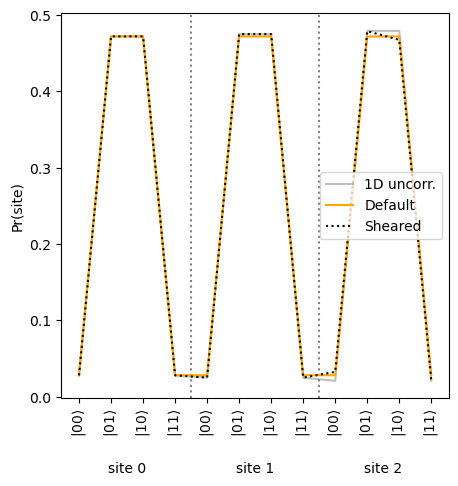

In [2]:
from plot_utils import plot_persite_combined

nL= 3 # Number of lattice sites
nQ= 2
dx = 1 # Lattice spacing, usually called a in the lattice literature
dp = 2*np.pi/(nL*dx)
twist = 1 # Physical lattice twist in units of pi
r= int(nQ - 1 + np.ceil(np.log2(nL-1)))
num_ancilla= 2*r + 1


lat_sft = sft_lattice(1, nL, dx, nQ, num_ancilla, twisted=twist)
# Targ = target / default
qc_Targ= QuantumCircuit(lat_sft.get_q_register())
gs_Targ= lat_sft.ground_state(qc_Targ, lat_sft.get_q_register(), full_correlation= True, shear= False)

#gs_Targ.build(qc_Targ, lat_sft.get_q_register())

# NS = not sheared, 1D uncorrelated Gaussians
#gs_NS= lattice_sft.ground_state(lat_sft, full_correlation= False, shear= False)
qc_NS= QuantumCircuit(lat_sft.get_q_register())
gs_NS= lat_sft.ground_state(qc_NS, lat_sft.get_q_register(), full_correlation= False, shear= False)
#gs_NS.build(qc_NS, lat_sft.lattice.get_q_register())

# S = sheared, KW
#gs_S= lattice_circ.ground_state(lat, full_correlation= False, shear= True)
qc_S= QuantumCircuit(lat_sft.get_q_register(), lat_sft.get_a_register())
gs_S= lat_sft.ground_state(qc_S, lat_sft.get_q_register(), q_ancillas=lat_sft.get_a_register(), full_correlation= False, shear= True)

#gs_S.build(qc_S, lat.get_q_register(), lat.get_a_register())
#gs_S.build(qc_NS, lat_sft.lattice.get_q_register())

sv_Targ= execute(qc_Targ, simulator_state).result().get_statevector(qc_Targ)
sv_NS= execute(qc_NS, simulator_state).result().get_statevector(qc_NS)
sv_S= execute(qc_S, simulator_state).result().get_statevector(qc_S)


plot_persite_combined([np.abs(sv_NS)**2, np.abs(sv_Targ)**2, np.abs(sv_S)**2],
                      nQ, nL, ["1D uncorr.", "Default", "Sheared"], [False, False, False])




## Plot eigenstated-ness against time, to measure trotterization error

In [3]:
# Same lattice object as previous cell
#lat_sft.phiMax = 0.1
evolve_times = []
ground_state_prob = []

for evolve_time in np.logspace(-3,np.log(2)/np.log(10),20):
    
    circ= QuantumCircuit(lat_sft.get_q_register())
    circ.compose(qc_Targ, inplace=True)
    
    evo= evolution(lat_sft, evolve_time, trotter_steps= 1)
    evo.build(circ, lat_sft.get_q_register())
    
    circ.compose(qc_Targ.inverse(), inplace=True)
    
    result = execute(circ, simulator_state).result()
    statevector = result.get_statevector(circ)
    
    evolve_times += [evolve_time]
    ground_state_prob += [abs(statevector[0])**2]

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


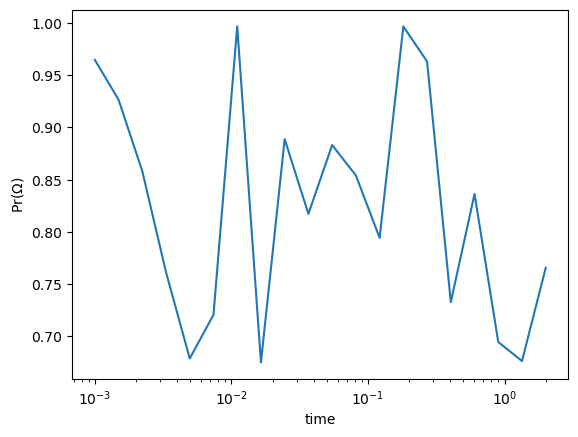

In [4]:
plt.plot(evolve_times,ground_state_prob)
plt.xlabel("time")
plt.ylabel("Pr($\Omega$)")
plt.xscale("log")

# Gate counting

In [5]:
def count_cxs(mycirc):
    mycount = 0
    if 'cx' in mycirc.count_ops():
        mycount += mycirc.count_ops()['cx']
    if 'swap' in mycirc.count_ops():
        mycount += 3*mycirc.count_ops()['swap']
    return mycount

def count_singleq(mycirc):
    mycount = 0
    for mytype in mycirc.count_ops():
        if 'cx' in mytype or 'swap' in mytype:
            continue
        else:
            mycount+=mycirc.count_ops()[mytype]
    return mycount

In [6]:
nL= 3 # Number of lattice sites
dx= 1. # Lattice spacing, usually called a in the lattice literature
g= 1. # Wilson line coupling constant
dim= 1
num_ancilla= 1

nQs= []

#CNOT + 3 x SWAP
nCs_trotter= []
nCs_state= []
nCs_wilson= []

#single qubit
nSs_trotter= []
nSs_state= []
nSs_wilson= []

for nQ in range(1,5):
    
    print("Doing nQ=", nQ)

    lat_sft= sft_lattice(dim, nL, dx, nQ, num_ancilla)
    omegalist= lat_sft.omega_list()
    #print(omegalist)
    av_omega= np.sum(omegalist) / lat_sft._nL
    lat_sft.phiMax= math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega)
    
    qc= QuantumCircuit(lat_sft.get_q_register())
    gs= lat_sft.ground_state(qc, lat_sft.get_q_register(), full_correlation=False, shear= False)
    #gs.build(qc, lat.get_q_register())
    
    ## Hamiltonian evolution
    evolve_time, trotter_steps= 0.001, 1
    
    qc_evolve= QuantumCircuit(lat_sft.get_q_register())
    evo= evolution(lat_sft, evolve_time, trotter_steps)
    evo.build(qc_evolve, lat_sft.get_q_register())
    
    qc_wilson= QuantumCircuit(lat_sft.get_q_register())
    # The two lines below combine time evolution with the Wilson line operator:
    wilson= wilson_line(lat_sft, [1], [-1], g, trotter_steps)
    wilson.build(qc_wilson, lat_sft.get_q_register())
    
    qc_transpiled= compiler.transpile(qc, basis_gates=['h', 't', 'tdg', 'x', 'cx', 'ry', 'rx', 'rz', 'u1'], optimization_level= 0)
    qc_evolve_transpiled= compiler.transpile(qc_evolve, basis_gates=['h', 't', 'tdg', 'x', 'cx', 'ry', 'rx', 'rz', 'u1'], optimization_level= 0)
    qc_wilson_transpiled= compiler.transpile(qc_wilson, basis_gates=['h', 't', 'tdg', 'x', 'cx', 'ry', 'rx', 'rz', 'u1'], optimization_level= 0)

    nCs_state+=[count_cxs(qc_transpiled)]
    nCs_trotter+=[count_cxs(qc_evolve_transpiled)]
    nCs_wilson+=[count_cxs(qc_wilson_transpiled)]
    
    nSs_state+=[count_singleq(qc_transpiled)]
    nSs_trotter+=[count_singleq(qc_evolve_transpiled)]
    nSs_wilson+=[count_singleq(qc_wilson_transpiled)]
    
    nQs+=[nQ]

Doing nQ= 1
0.7674950309598664
0.7674950309598664
0.7674950309598664
0.7674950309598664
0.7674950309598664
0.7674950309598664
0.7674950309598664
0.7674950309598664
0.7674950309598664
Doing nQ= 2
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
Doing nQ= 3
2.6862326083595325
2.6862326083595325
2.6862326083595325
2.6862326083595325
2.6862326083595325
2.6862326083595325
2.6862326083595325
2.6862326083595325
2.6862326083595325
Doing nQ= 4
4.070257056890256
4.070257056890256
4.070257056890256
4.070257056890256
4.070257056890256
4.070257056890256
4.070257056890256
4.070257056890256
4.070257056890256


CNOTS ================
nQ, State, Hamiltonian, Wilson
1    0       6           12
2    6      48           96
3   18     126          252
4   42     240          480


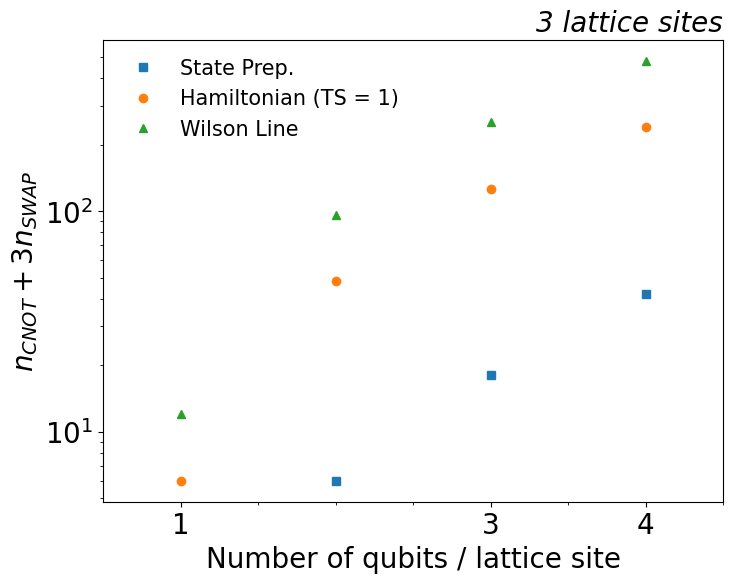

In [7]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(nQs,nCs_state,marker='s',ls="none",label="State Prep.")
plt.plot(nQs,nCs_trotter,marker='o',ls="none",label="Hamiltonian (TS = 1)")
plt.plot(nQs,nCs_wilson,marker='^',ls="none",label="Wilson Line")
plt.xlabel("Number of qubits / lattice site",fontsize=20)
plt.ylabel("$n_{CNOT} + 3 n_{SWAP}$",fontsize=20)
plt.title("3 lattice sites",style="italic",loc="right",fontsize=20)
plt.yscale("log")
plt.xticks([1,3,4])
plt.xlim([0.5,4.5])
plt.legend(frameon=False,fontsize=15,loc=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

print("CNOTS ================")
print("nQ, State, Hamiltonian, Wilson")
for i in range(len(nQs)):
    print("{:1d}  {:3d}     {:3d}          {:3d}".format(nQs[i],nCs_state[i],nCs_trotter[i],nCs_wilson[i]))

CNOTS ================
nQ, State, Hamiltonian, Wilson
1     3     69          140
2     9    144          292
3    21    249          504
4    45    384          776


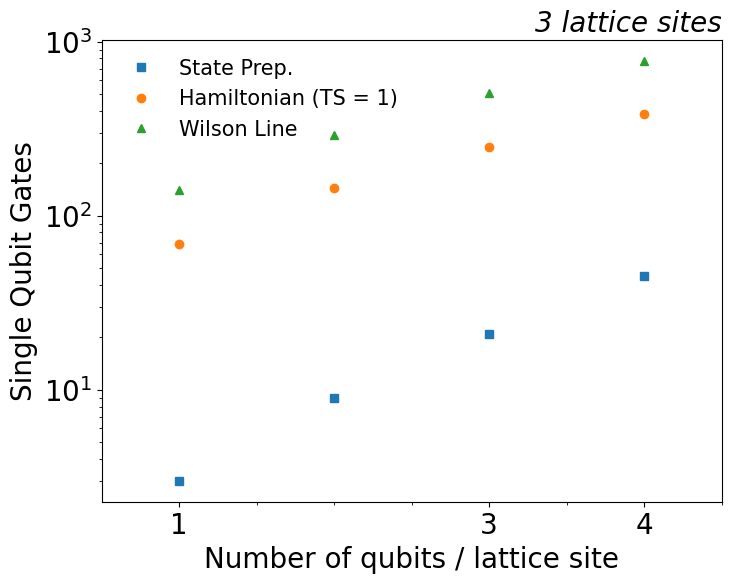

In [8]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(nQs,nSs_state,marker='s',ls="none",label="State Prep.")
plt.plot(nQs,nSs_trotter,marker='o',ls="none",label="Hamiltonian (TS = 1)")
plt.plot(nQs,nSs_wilson,marker='^',ls="none",label="Wilson Line")
plt.xlabel("Number of qubits / lattice site",fontsize=20)
plt.ylabel("Single Qubit Gates",fontsize=20)
plt.title("3 lattice sites",style="italic",loc="right",fontsize=20)
plt.yscale("log")
plt.xticks([1,3,4])
plt.xlim([0.5,4.5])
plt.legend(frameon=False,fontsize=15,loc=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

print("CNOTS ================")
print("nQ, State, Hamiltonian, Wilson")
for i in range(len(nQs)):
    print("{:1d}   {:3d}    {:3d}          {:3d}".format(nQs[i],nSs_state[i],nSs_trotter[i],nSs_wilson[i]))

## Compare Wilson line implementations for 3 lattice sites

In [12]:
nL= 3 # Number of lattice sites
nQ= 2
dx= 1. # Lattice spacing, usually called a in the lattice literature
g= 0.5 # Wilson line coupling constant
dim= 1
num_ancilla= 1

lat_sft = sft_lattice(dim, nL, dx, nQ, num_ancilla)
omegalist = lat_sft.omega_list()
av_omega = np.sum(omegalist) / lat_sft._nL
lat_sft.phi_max = math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega)

qc_gs= QuantumCircuit(lat_sft.get_q_register())
gs= lat_sft.ground_state(qc_gs, lat_sft.get_q_register(), full_correlation= False, shear= False)
#gs.build(qc_gs, lat.get_q_register())
    
qc_wilson1= QuantumCircuit(lat_sft.get_q_register())
wilson= wilson_line(lat_sft, [1], [-1], g, 15)
qc_wilson1.compose(qc_gs.to_gate(label='StatePrep'), qc_wilson1.qubits[:], inplace=True)
wilson.build(qc_wilson1, lat_sft.get_q_register())
qc_wilson1.compose(qc_gs.inverse().to_gate(label='invStatePrep'), qc_wilson1.qubits[:], inplace=True)

qc_wilson2= QuantumCircuit(lat_sft.get_q_register())
phi = basic_op_cf.PhiOperator(lat_sft.phiMax)

qc_wilson2.compose(qc_gs.to_gate(label='StatePrep'), qc_wilson2.qubits[:], inplace=True)
qc_wilson2.compose(lat_sft.apply_single_operator_list([[[2], phi, [-g * dx]], [[0], phi,[g * dx]]]))
qc_wilson2.compose(qc_gs.inverse().to_gate(label='invStatePrep'), qc_wilson2.qubits[:], inplace=True)

sv1= execute(qc_wilson1, simulator_state).result().get_statevector()
sv2= execute(qc_wilson2, simulator_state).result().get_statevector()

print("Fidelity= " + str(qiskit.quantum_info.state_fidelity(sv1, sv2)))
print("Note: the fidelity error is due to trotterization in the general implementation of Wilson lines.")
#qiskit.visualization.plot_histogram(result1.get_counts())
print(qc_wilson1.draw())
print(qc_wilson2.draw())

1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
1.628102822756102
Fidelity= 0.7298686792308408
Note: the fidelity error is due to trotterization in the general implementation of Wilson lines.
        ┌────────────┐┌─────────┐┌─────────────┐┌──────────────┐»
q973_0: ┤0           ├┤0        ├┤ Rz(-0.5427) ├┤0             ├»
        │            ││         │├─────────────┤│              │»
q973_1: ┤1           ├┤1        ├┤ Rz(-1.0854) ├┤1             ├»
        │            ││         │└─────────────┘│              │»
q973_2: ┤2           ├┤2        ├───────────────┤2             ├»
        │  StatePrep ││  Evolve │               │  inv(Evolve) │»
q973_3: ┤3           ├┤3        ├───────────────┤3             ├»
        │            ││         │ ┌────────────┐│              │»
q973_4: ┤4           ├┤4        ├─┤ Rz(0.5427) ├┤4             ├»
        │            ││         │ ├────────────┤│              │»
q973_5: ┤5           ├┤5        ├─┤ Rz(1

# Estimating matrix elements for different couplings, nL= 3, nQ= 2

In [14]:
nL= 3 # Number of lattice sites
nQ= 2
dx= 1. # Lattice spacing, usually called a in the lattice literature
g= 0.526 # Wilson line coupling constant
dim= 1
num_ancilla= 1
trotter_per_dt1= 1
trotter_per_dt2= 2

gList= []
ampList_trotterized1= []
ampList_trotterized2= []
ampList_analytical= []
fidels= []

for g in np.linspace(0,1,20):
    lat_sft = sft_lattice(dim, nL, dx, nQ, num_ancilla)
    omegalist = lat_sft.omega_list()
    av_omega = np.sum(omegalist) / lat_sft._nL
    lat_sft.phiMax = math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega)
    
    # Construct ground state
    qc_gs= QuantumCircuit(lat_sft.get_q_register())
    gs= lat_sft.ground_state(qc_gs, lat_sft.get_q_register(), full_correlation= True, shear= False)
    #gs.build(qc_gs, lat.get_q_register())
    
    # Simplified analytical Wilson line operator for nL= 3 sites per dimension
    qc_wl_simple= QuantumCircuit(lat_sft.get_q_register())
    phi= basic_op_cf.PhiOperator(lat_sft.phiMax)
    qc_wl_simple.compose(lat_sft.apply_single_operator_list([[[2],phi,[-g * dx]],[[0],phi,[g * dx]]]), inplace=True)

    qc= QuantumCircuit(lat_sft.get_q_register())
    qc.compose(qc_gs, inplace=True)
    qc.compose(qc_wl_simple, inplace=True)
    qc.compose(qc_gs.inverse(), inplace=True)

    sv= execute(qc, simulator_state).result().get_statevector()
    prob= abs(sv[0])**2

    gList.append(g)
    ampList_analytical.append(prob)
    
    # General Wilson line operator, trotter steps value 1
    qc_wl= QuantumCircuit(lat_sft.get_q_register())
    wilson= wilson_line(lat_sft, [1], [-1], g, trotter_per_dt1)
    wilson.build(qc_wl, lat_sft.get_q_register())
    
    qc= QuantumCircuit(lat_sft.get_q_register())
    qc.compose(qc_gs, inplace=True)
    qc.compose(qc_wl, inplace=True)
    qc.compose(qc_gs.inverse(), inplace=True)

    sv1= execute(qc, simulator_state).result().get_statevector()
    prob1= abs(sv1[0])**2

    ampList_trotterized1.append(prob1)
    
    # General Wilson line operator, trotter steps value 2
    qc_wl2= QuantumCircuit(lat_sft.get_q_register())
    wilson= wilson_line(lat_sft, [1], [-1], g, trotter_per_dt2)
    wilson.build(qc_wl2, lat_sft.get_q_register())

    qc= QuantumCircuit(lat_sft.get_q_register())
    qc.compose(qc_gs, inplace=True)
    qc.compose(qc_wl2, inplace=True)
    qc.compose(qc_gs.inverse(), inplace=True)

    sv2= execute(qc, simulator_state).result().get_statevector()
    prob2= abs(sv2[0])**2

    ampList_trotterized2.append(prob2)
    
    fidels.append(qiskit.quantum_info.state_fidelity(sv, sv2))

1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227

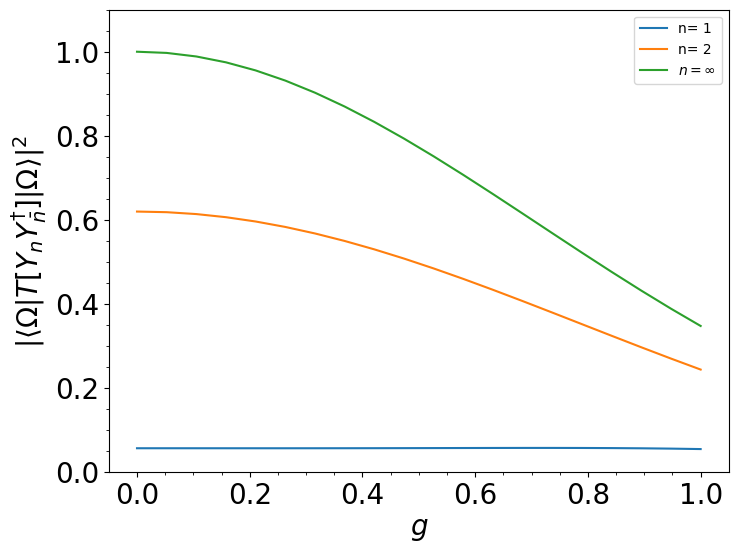

In [15]:
#qc.draw('mpl')
#plt.plot(gList, ampList)

plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(gList, ampList_trotterized1, label='n= %d' %(trotter_per_dt1))
plt.plot(gList, ampList_trotterized2, label='n= %d' %(trotter_per_dt2))
plt.plot(gList, ampList_analytical, label= r'$n= \infty$')

#plt.plot(xx_sim,np.abs(yy_sim_p1))
#plt.plot(xx_sim,np.abs(yy_sim_p1_approx))
plt.ylim([0,1.1])
plt.xlabel("$g$",fontsize=20)
plt.ylabel(r"$|\langle \Omega | T[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2$",fontsize=20)
plt.legend()

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

## Generage Fig. 4 -- Ground eigenstate-ness as a function of evolution time

In [19]:
nL= 3 # Number of lattice sites
nQ= 2
dx= 1. # Lattice spacing, usually called a in the lattice literature
g= 0.526 # Wilson line coupling constant
dim= 1
num_ancilla= 1
trotter_steps = 10

probs1= []
probs2= []
probs3 = []

fctr1 = []
fctr2 = []
fctr3 = []

xticks0 = np.arange(0, np.pi + np.pi/60., np.pi/30.)

for evolve_time in xticks0:
    print(evolve_time)
    latt_sft = sft_lattice(dim, nL, dx, nQ, num_ancilla)
    omegalist = latt_sft.omega_list()
    av_omega = np.sum(omegalist) / latt_sft._nL
    latt_sft.phiMax = math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega)
    
    qc_state = QuantumCircuit(latt_sft.get_q_register())
    ground_state = latt_sft.ground_state(qc_state, latt_sft.get_q_register(), full_correlation=False, shear= False)
    #qc_state = QuantumCircuit(latt_sft.lattice.get_q_register())
    #ground_state.build(qc_state, lattice.get_q_register())
    
    evolve_Trotter1 = QuantumCircuit(latt_sft.get_q_register())
    evo1 = evolution(latt_sft, evolve_time=evolve_time, trotter_steps=int(5*evolve_time))
    evo1.build(evolve_Trotter1, latt_sft.get_q_register())
    #print(evo1.build(evolve_Trotter1, lattice.get_q_register()).draw())

    evolve_Trotter2 = QuantumCircuit(latt_sft.get_q_register())
    evo2 = evolution(latt_sft, evolve_time=evolve_time, trotter_steps=1)
    evo2.build(evolve_Trotter2, latt_sft.get_q_register())
    
    evolve_Trotter3= QuantumCircuit(latt_sft.get_q_register())
    evo3 = evolution(latt_sft, evolve_time=evolve_time, trotter_steps=trotter_steps)
    evo3.build(evolve_Trotter3, latt_sft.get_q_register())

    qc = QuantumCircuit(latt_sft.get_q_register())
    qc.compose(qc_state, inplace=True)
    qc.compose(evolve_Trotter1, inplace=True)
    qc.compose(qc_state.inverse(), inplace=True)
    result = execute(qc, simulator_state).result()
    sv= result.get_statevector()
    prob= abs(sv[0])**2
    probs1.append(prob)
    fctr1.append(abs(1 + sv[0])**2 / 4.)
    
    qc= QuantumCircuit(latt_sft.get_q_register())
    qc.compose(qc_state, inplace=True)
    qc.compose(evolve_Trotter2, inplace=True)
    qc.compose(qc_state.inverse(), inplace=True)
    result= execute(qc, simulator_state).result()
    sv= result.get_statevector()
    prob= abs(sv[0])**2
    probs2.append(prob)
    fctr2.append(abs(1 + sv[0])**2 / 4.)
    
    qc= QuantumCircuit(latt_sft.get_q_register())
    qc.compose(qc_state, inplace=True)
    qc.compose(evolve_Trotter3, inplace=True)
    qc.compose(qc_state.inverse(), inplace=True)
    result= execute(qc, simulator_state).result()
    sv= result.get_statevector()
    prob= abs(sv[0])**2
    probs3.append(prob)
    fctr3.append(abs(1 + sv[0])**2 / 4.)

0.0
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.10471975511965977
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.20943951023931953
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.3141592653589793
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.41887902047863906
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.5235987755982988
1.6281028227561023
1.6281028227561023
1.628

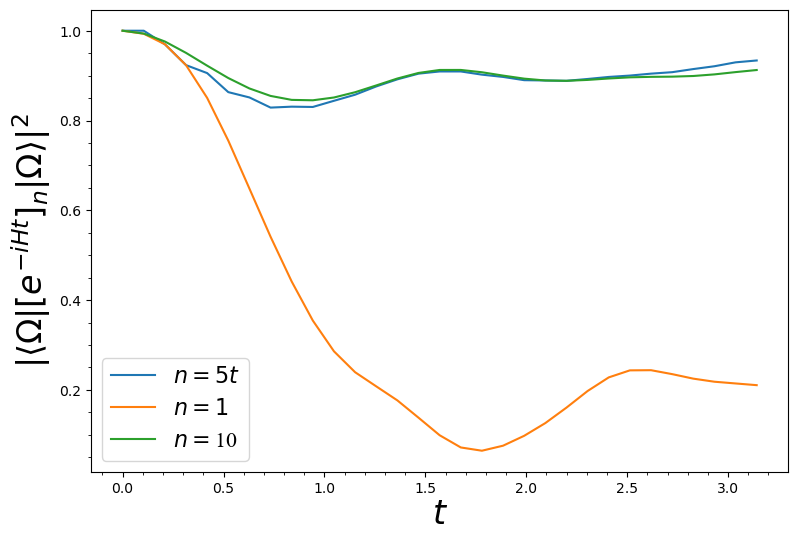

In [20]:
plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(xticks0, probs1, label=r'$n= 5t$')
plt.plot(xticks0, probs2, label=r'$n= 1$')
plt.plot(xticks0, probs3, label=r'$n= $%d' %(trotter_steps))
plt.ylabel(r"$|\langle \Omega \left| \left[e^{-iHt}\right]_n \right| \Omega\rangle|^2$", fontname='times new roman', fontsize=24)
plt.xlabel(r'$t$', fontname='times new roman', fontsize=24)
plt.legend(prop=mpl.font_manager.FontProperties(family='times new roman', size= 16))

ax0.minorticks_on()
#print(probs2)

## Genereate Fig. 5 -- fraction of measurements in the state '0...0'

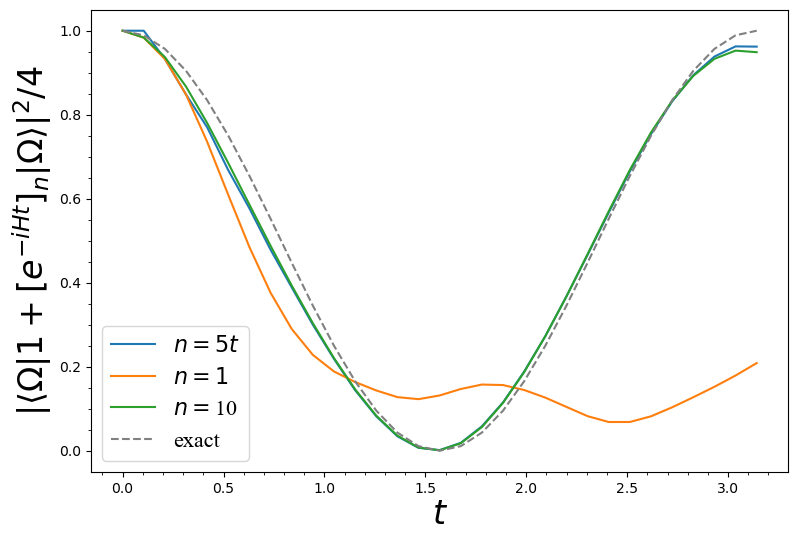

In [21]:
plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(xticks0, fctr1, label=r'$n= 5t$')
plt.plot(xticks0, fctr2, label=r'$n= 1$')
plt.plot(xticks0, fctr3, label=r'$n= $%d' %(trotter_steps))
plt.plot(xticks0, np.cos(xticks0 * latt_sft.ground_state_energy() / 2.)**2, linestyle= '--', color='gray', label='exact')
plt.ylabel(r"$|\langle \Omega \left| 1 + \left[e^{-iHt}\right]_n \right| \Omega\rangle|^2 / 4$", fontname='times new roman', fontsize=24)
plt.xlabel(r'$t$', fontname='times new roman', fontsize=24)
plt.legend(prop=mpl.font_manager.FontProperties(family='times new roman', size= 16))

ax0.minorticks_on()

#plt.savefig('old_build_correctPhi2Pi2DoublePhi.pdf')


## Generate FIG. 5 using the circuit above S58

In [22]:
nL= 3 # Number of lattice sites
nQ= 2
dx= 1. # Lattice spacing, usually called a in the lattice literature
g= 0.526 # Wilson line coupling constant
dim= 1
num_ancilla= 1
trotter_steps = 10

fctr1= []
fctr2= []
fctr3= []

xticks= np.arange(0, np.pi + np.pi/60., np.pi/30.)

for evolve_time in xticks:
    print(evolve_time)
    lat_sft= sft_lattice(dim, nL, dx, nQ, num_ancilla)
    omegalist= lat_sft.omega_list()
    av_omega= np.sum(omegalist) / lat_sft._nL
    lat_sft.phiMax= math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega)
    
    qreg= lat_sft.get_q_register()
    areg= lat_sft.get_a_register()

    qc_state= QuantumCircuit(qreg)
    gs= lat_sft.ground_state(qc_state, qreg, full_correlation=False, shear= False)
    #gs.build(qc_state, qreg)
    
    qc_evolve1= QuantumCircuit(qreg)
    evo1= evolution(lat_sft, evolve_time=evolve_time, trotter_steps=int(5*evolve_time))
    evo1.build(qc_evolve1, qreg)
    
    qc_evolve2= QuantumCircuit(qreg)
    evo2= evolution(lat_sft, evolve_time=evolve_time, trotter_steps=1)
    evo2.build(qc_evolve2, qreg)
    
    qc_evolve3= QuantumCircuit(qreg)
    evo3= evolution(lat_sft, evolve_time=evolve_time, trotter_steps=trotter_steps)
    evo3.build(qc_evolve3, qreg)

    qc= QuantumCircuit(qreg, areg)
    #qc.compose(qc_state, qc.qubits[:-1], inplace=True)
    qc.compose(qc_state, qreg, inplace=True)
    
    #qc+= qc_evolve1
    qc.h(-1)
    qc.compose(qc_evolve1.to_gate().control(1), [qc.qubits[-1]] + qc.qubits[:-1], inplace=True)
    qc.h(-1)
    
    qc.compose(qc_state.inverse(), qc.qubits[:-1], inplace=True)
    sv= execute(qc, simulator_state).result().get_statevector()
    fctr1.append(abs(sv[0])**2)
    
    qc= QuantumCircuit(qreg, areg)
    #qc.compose(qc_state, qc.qubits[:-1], inplace=True)
    qc.compose(qc_state, qreg, inplace=True)
    
    #qc+= qc_evolve2
    qc.h(-1)
    qc.compose(qc_evolve2.to_gate().control(1), [qc.qubits[-1]] + qc.qubits[:-1], inplace=True)
    qc.h(-1)
    
    qc.compose(qc_state.inverse(), qc.qubits[:-1], inplace=True)
    sv= execute(qc, simulator_state).result().get_statevector()
    fctr2.append(abs(sv[0])**2)
    
    qc= QuantumCircuit(qreg, areg)
    #qc.compose(qc_state, qc.qubits[:-1], inplace=True)
    qc.compose(qc_state, qreg, inplace=True)
    
    #qc+= qc_evolve3
    qc.h(-1)
    qc.compose(qc_evolve3.to_gate().control(1), [qc.qubits[-1]] + qc.qubits[:-1], inplace=True)
    qc.h(-1)
    
    qc.compose(qc_state.inverse(), qc.qubits[:-1], inplace=True)
    sv= execute(qc, simulator_state).result().get_statevector()
    fctr3.append(abs(sv[0])**2)

0.0
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.10471975511965977
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.20943951023931953
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.3141592653589793
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.41887902047863906
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
0.5235987755982988
1.6281028227561023
1.6281028227561023
1.628

[0.9999999999999996, 0.9834282566177124, 0.932812388578505, 0.8481480862060733, 0.7355781215354458, 0.6089146347613555, 0.48477796790778965, 0.3761636844598708, 0.28994098178478694, 0.22817720512466905, 0.1886969235870019, 0.16358269000841888, 0.1435138352527934, 0.12763107178012337, 0.12277167303700987, 0.131563345985718, 0.1469518077205069, 0.15754288132005168, 0.15633058278153344, 0.14455971290469508, 0.12640082892229973, 0.10426395676337949, 0.08231165600515357, 0.06836123379045472, 0.06844022573312508, 0.08195717512776095, 0.10334143966218455, 0.12731410785609681, 0.15220985039356874, 0.17908596861150372, 0.20869874285712245]


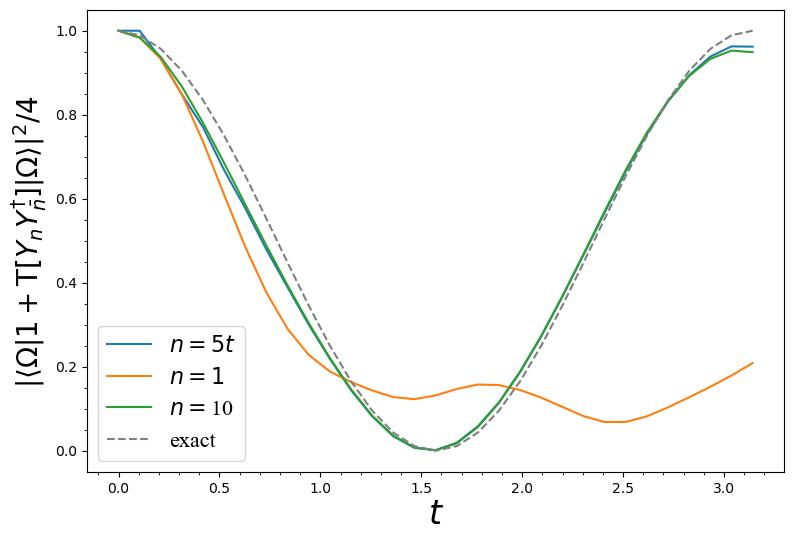

In [23]:
plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(xticks, fctr1, label=r'$n= 5t$')
plt.plot(xticks, fctr2, label=r'$n= 1$')
plt.plot(xticks, fctr3, label=r'$n= $%d' %(trotter_steps))
plt.plot(xticks, np.cos(xticks * latt_sft.ground_state_energy() / 2.)**2, linestyle= '--', color='gray', label='exact')
plt.ylabel(r'$|\langle \Omega | 1 + \mathrm{T}[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2/4$', fontname='times new roman', fontsize=20)

plt.xlabel(r'$t$', fontname='times new roman', fontsize=24)
plt.legend(prop=mpl.font_manager.FontProperties(family='times new roman', size= 16))

ax0.minorticks_on()
#qc.draw()
#plt.savefig('old_buildGC_correctPhi2Pi2DoublePhi.pdf')
#plt.savefig('new__NewSettings_GateControl.pdf')
print(fctr2)

In [24]:
qcT= compiler.transpile(qc, basis_gates=['h', 't', 'tdg', 'x', 'cx', 'ry', 'rx', 'rz', 'u1'], optimization_level= 0)
print(qcT.count_ops())
qc.draw()

#OrderedDict([('rz', 648), ('cx', 516), ('rx', 432), ('u1', 216), ('t', 192), ('tdg', 144), ('h', 98), ('ry', 18), ('x', 12)])

OrderedDict([('cx', 5412), ('u1', 3061), ('t', 1920), ('rz', 1800), ('tdg', 1440), ('rx', 1200), ('h', 962), ('ry', 18)])


┌───────┐┌─────────────────┐┌──────────┐
q10982_0: ┤0      ├┤0                ├┤0         ├
          │  P(X) ││                 ││  P(X)_dg │
q10982_1: ┤1      ├┤1                ├┤1         ├
          ├───────┤│                 │├──────────┤
q10982_2: ┤0      ├┤2                ├┤0         ├
          │  P(X) ││  circuit-140131 ││  P(X)_dg │
q10982_3: ┤1      ├┤3                ├┤1         ├
          ├───────┤│                 │├──────────┤
q10982_4: ┤0      ├┤4                ├┤0         ├
          │  P(X) ││                 ││  P(X)_dg │
q10982_5: ┤1      ├┤5                ├┤1         ├
          └─┬───┬─┘└────────┬────────┘└──┬───┬───┘
  q10983: ──┤ H ├───────────■────────────┤ H ├────
            └───┘                        └───┘

## Generate FIG. 5 using the circuit above S58, using CircuitFactory.build_controlled(). WARNING: does not construct the correct circuit

In [25]:
nL= 3 # Number of lattice sites
nQ= 2
dx= 1. # Lattice spacing, usually called a in the lattice literature
g= 0.526 # Wilson line coupling constant
dim= 1
num_ancilla= 1
trotter_steps = 10

fctr1= []
fctr2= []
fctr3= []

xticks= np.arange(0, np.pi + np.pi/60., np.pi/30.)

for evolve_time in xticks:
    print(evolve_time)
    latt_sft = sft_lattice(dim, nL, dx, nQ, num_ancilla)
    omegalist = latt_sft.omega_list()
    av_omega = np.sum(omegalist) / latt_sft._nL
    latt_sft.phiMax = math.sqrt(math.pi/2 * (2**nQ - 1)**2 / 2**nQ) / math.sqrt(av_omega)
    
    qc_state = QuantumCircuit(latt_sft.get_q_register())
    ground_state = latt_sft.ground_state(qc_state, latt_sft.get_q_register(), full_correlation=False, shear= False)
    #ground_state.build(qc_state, lattice.get_q_register())
    
    qreg= latt_sft.get_q_register()
    areg= latt_sft.get_a_register()
    
    tmp = evolution(latt_sft, evolve_time=evolve_time, trotter_steps=int(5*evolve_time))
    evo1 = QuantumCircuit(qreg)
    tmp.build(evo1, qreg, areg[0])
    custom1 = evo1.to_gate().control(areg.size)
    length = qreg.size
    list = [i for i in range(length)]
    list.insert(0,length)
    evolve_Trotter1= QuantumCircuit(qreg, areg)
    evolve_Trotter1.append(custom1, list)

    


    evo_qc2 = QuantumCircuit(qreg)
    evolve_Trotter2= QuantumCircuit(qreg, areg)
    evo2 = evolution(latt_sft, evolve_time=evolve_time, trotter_steps=1)
    evo2.build(evo_qc2, qreg)
    evo2.build_connection(evo_qc2, evolve_Trotter2, qreg, areg)
    
    
    #evolve_Trotter3= QuantumCircuit(qreg, areg)
    #evo3= lattice_circ.evolution(lattice, evolve_time=evolve_time, trotter_steps=trotter_steps)
    #evo3.build(evolve_Trotter3, qreg, areg[0])
    evo_qc3 = QuantumCircuit(qreg)
    evolve_Trotter3= QuantumCircuit(qreg, areg)
    evo3 = evolution(latt_sft, evolve_time=evolve_time, trotter_steps=trotter_steps)
    evo3.build(evo_qc3, qreg)
    evo3.build_connection(evo_qc3, evolve_Trotter3, qreg, areg)
    
    qc= QuantumCircuit(qreg, areg)
    qc.compose(qc_state, qc.qubits[:-1], inplace=True)

    qc.h(-1)
    qc.compose(evolve_Trotter1, qc.qubits[:], inplace=True)
    qc.h(-1)
    
    qc.compose(qc_state.inverse(), qc.qubits[:-1], inplace=True)
   #print(qc.draw())
    result= execute(qc, simulator_state).result()
    sv= result.get_statevector()
    fctr1.append(abs(sv[0])**2)
    
    qc= QuantumCircuit(qreg, areg)
    qc.compose(qc_state, qc.qubits[:-1], inplace=True)
    
    qc.h(-1)
    qc.compose(evolve_Trotter2, qc.qubits[:], inplace=True)
    qc.h(-1)
    
    qc.compose(qc_state.inverse(), qc.qubits[:-1], inplace=True)
    result= execute(qc, simulator_state).result()
    sv= result.get_statevector()
    fctr2.append(abs(sv[0])**2)
    
    qc= QuantumCircuit(qreg, areg)
    qc.compose(qc_state, qc.qubits[:-1], inplace=True)
    
    qc.h(-1)
    qc.compose(evolve_Trotter3, qc.qubits[:], inplace=True)
    qc.h(-1)
    
    qc.compose(qc_state.inverse(), qc.qubits[:-1], inplace=True)
    result= execute(qc, simulator_state).result()
    sv= result.get_statevector()
    fctr3.append(abs(sv[0])**2)

0.0
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
0.10471975511965977
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
0.20943951023931953
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
0.3141592653589793
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
0.41887902047863906
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
1.6281028227561023
1.6281028227561023
1.6281028227561023
1
0.5235987755982988
1.6281028227561023
1.62

[0.9999999999999996, 0.9834282566177124, 0.932812388578505, 0.8481480862060733, 0.7355781215354458, 0.6089146347613555, 0.48477796790778965, 0.3761636844598708, 0.28994098178478694, 0.22817720512466905, 0.1886969235870019, 0.16358269000841888, 0.1435138352527934, 0.12763107178012337, 0.12277167303700987, 0.131563345985718, 0.1469518077205069, 0.15754288132005168, 0.15633058278153344, 0.14455971290469508, 0.12640082892229973, 0.10426395676337949, 0.08231165600515357, 0.06836123379045472, 0.06844022573312508, 0.08195717512776095, 0.10334143966218455, 0.12731410785609681, 0.15220985039356874, 0.17908596861150372, 0.20869874285712245]
OrderedDict([('P(X)', 3), ('P(X)_dg', 3), ('h', 2), ('ccircuit-253706', 1)])


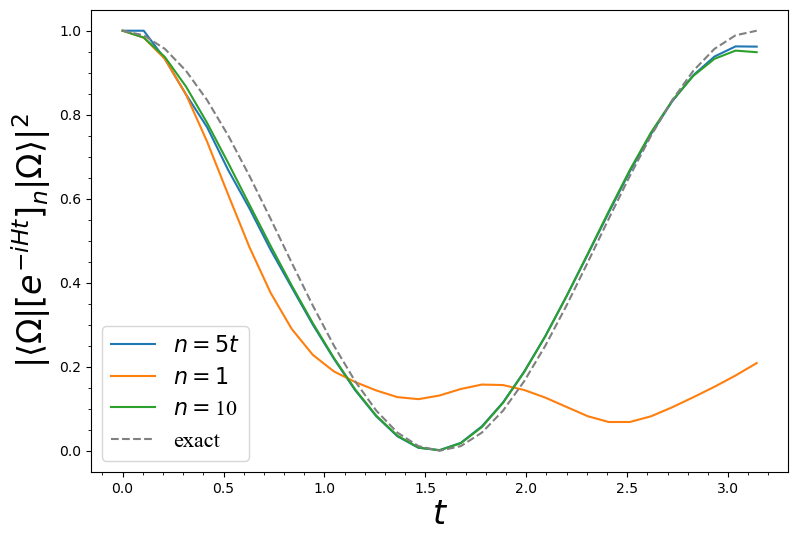

In [26]:
plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(xticks, fctr1, label=r'$n= 5t$')
plt.plot(xticks, fctr2, label=r'$n= 1$')
plt.plot(xticks, fctr3, label=r'$n= $%d' %(trotter_steps))
plt.plot(xticks, np.cos(xticks * latt_sft.ground_state_energy() / 2.)**2, linestyle= '--', color='gray', label='exact')
plt.ylabel(r"$|\langle \Omega | [e^{-iHt}]_n | \Omega\rangle|^2$", fontname='times new roman', fontsize=24)
plt.xlabel(r'$t$', fontname='times new roman', fontsize=24)
plt.legend(prop=mpl.font_manager.FontProperties(family='times new roman', size= 16))

ax0.minorticks_on()

#plt.savefig('old_BuildControlled_correctPhi2Pi2DoublePhi.pdf')
#plt.savefig('S58_NewSettings_BuildControlled.pdf')

print(fctr2)
print(qc.count_ops())

# Generate FIG. 5 -- paper version

## Evaluate Circuits

In [27]:
tvals = np.linspace(0.0001,3,61)

QC_nL = 3 # Number of lattice sites
QC_dx = 1 # Lattice spacing, usually called a in the lattice literature
QC_nQ = 2 # Number of qubits per lattice site
QC_dim = 1
QC_num_ancilla = 1
QC_twist= True

simulator_QASM = Aer.get_backend('qasm_simulator')

tsim = np.linspace(0.2,3,15)
Exact1StepSim = np.zeros_like(tsim)
Exact1StepErr = np.zeros_like(tsim)
Exact5XStepSim = np.zeros_like(tsim)
Exact5XStepErr = np.zeros_like(tsim)

KW1StepSim = np.zeros_like(tsim)
KW1StepErr = np.zeros_like(tsim)
KW5XStepSim = np.zeros_like(tsim)
KW5XStepErr = np.zeros_like(tsim)

QC_lat_sft = sft_lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla, twisted=QC_twist)

stateq = QC_lat_sft.get_q_register()
statecontrol = QC_lat_sft.get_a_register()

qc_gs = QuantumCircuit(stateq)
QC_ground_state = QC_lat_sft.ground_state(qc_gs, stateq, full_correlation=True)
#QC_ground_state.build(qc_gs, stateq)
    
for tid, QC_t in enumerate(tsim):
    print(tid, QC_t)
    QC_omegalist = QC_lat_sft.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lat_sft._nL
    QC_lat_sft.phiMax = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC.compose(qc_gs, inplace=True)
    QC.barrier()
    
    #Evolution
    QC_evolution = evolution(QC_lat_sft, evolve_time=QC_t, trotter_steps=1)
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build(QC_evo_prep, stateq)
    QC.compose(QC_evo_prep.to_gate().control(1), [statecontrol[0]] + QC.qubits[:-1], inplace=True)
    QC.barrier()
    
    #Back to the ground state
    QC.compose(qc_gs.inverse(), inplace=True)
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()

    right_p = counts['0000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    Exact1StepSim[tid] = right_p
    Exact1StepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

for tid, QC_t in enumerate(tsim):
    print(tid, QC_t)
    QC_omegalist = QC_lat_sft.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lat_sft._nL
    QC_lat_sft.phiMax = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC.compose(qc_gs, inplace=True)
    QC.barrier()
    
    #Evolution
    QC_evolution = evolution(QC_lat_sft, evolve_time=QC_t, trotter_steps=math.ceil(5*QC_t))
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build(QC_evo_prep, stateq)
    QC.compose(QC_evo_prep.to_gate().control(1), [statecontrol[0]] + QC.qubits[:-1], inplace=True)
    QC.barrier()
    
    #Back to the ground state
    QC.compose(qc_gs.inverse(), inplace=True)
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['0000000']/sum(counts.values()) if '0000000' in counts.keys() else 0.
    total_res = sum(counts.values())
    
    Exact5XStepSim[tid] = right_p
    Exact5XStepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)
    
for tid, QC_t in enumerate(tsim):
    print(tid, QC_t)
    QC_omegalist = QC_lat_sft.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lat_sft._nL
    QC_lat_sft.phiMax = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC.compose(qc_gs, inplace=True)
    QC.barrier()
    
    #Evolution
    QC_evolution = evolution(QC_lat_sft, evolve_time=QC_t, trotter_steps=1)
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build(QC_evo_prep, stateq)
    QC.compose(QC_evo_prep.to_gate().control(1), [statecontrol[0]] + QC.qubits[:-1], inplace=True)
    QC.barrier()
    
    #Back to the ground state
    QC.compose(qc_gs.inverse(), inplace=True)
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()

    right_p = counts['0000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    KW1StepSim[tid] = right_p
    KW1StepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

for tid, QC_t in enumerate(tsim):
    print(tid, QC_t)
    QC_omegalist = QC_lat_sft.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lat_sft._nL
    QC_lat_sft.phiMax = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC.compose(qc_gs, inplace=True)
    QC.barrier()
    
    #Evolution
    QC_evolution = evolution(QC_lat_sft, evolve_time=QC_t, trotter_steps=math.ceil(5*QC_t))
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build(QC_evo_prep, stateq)
    QC.compose(QC_evo_prep.to_gate().control(1), [statecontrol[0]] + QC.qubits[:-1], inplace=True)
    QC.barrier()
    
    #Back to the ground state
    QC.compose(qc_gs.inverse(), inplace=True)
    QC.h(statecontrol)
    
    QC.measure_all()
    #print(QC.draw())
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['0000000']/sum(counts.values()) if '0000000' in counts.keys() else 0.
    total_res = sum(counts.values())
    
    KW5XStepSim[tid] = right_p
    KW5XStepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

0 0.2
1.6281028227561023
1.6281028227561023
1.6281028227561023
1 0.4
1.6281028227561023
1.6281028227561023
1.6281028227561023
2 0.6
1.6281028227561023
1.6281028227561023
1.6281028227561023
3 0.8
1.6281028227561023
1.6281028227561023
1.6281028227561023
4 1.0
1.6281028227561023
1.6281028227561023
1.6281028227561023
5 1.2
1.6281028227561023
1.6281028227561023
1.6281028227561023
6 1.4
1.6281028227561023
1.6281028227561023
1.6281028227561023
7 1.5999999999999999
1.6281028227561023
1.6281028227561023
1.6281028227561023
8 1.7999999999999998
1.6281028227561023
1.6281028227561023
1.6281028227561023
9 1.9999999999999998
1.6281028227561023
1.6281028227561023
1.6281028227561023
10 2.1999999999999997
1.6281028227561023
1.6281028227561023
1.6281028227561023
11 2.4
1.6281028227561023
1.6281028227561023
1.6281028227561023
12 2.6
1.6281028227561023
1.6281028227561023
1.6281028227561023
13 2.8
1.6281028227561023
1.6281028227561023
1.6281028227561023
14 3.0
1.6281028227561023
1.6281028227561023
1.6281028

## Classical expectations

In [28]:
lat_cl= cl.Lattice(QC_nL, QC_nQ, QC_dx, True)

groundExact = cl.createEigenstate([0]*QC_nL, lat_cl)
groundKW = cl.createKWground(lat_cl)

Exact1Step = [np.abs(groundExact.conj() @ (np.identity(lat_cl.nPhi()**lat_cl.nL) + cl.evolveHTrotter(t, 1 , lat_cl)) @ groundExact)**2/4 for t in tvals]
Exact5XStep = [np.abs(groundExact.conj() @ (np.identity(lat_cl.nPhi()**lat_cl.nL) + cl.evolveHTrotter(t, math.ceil(5*t), lat_cl)) @ groundExact)**2/4 for t in tvals]
KW1Step = [np.abs(groundKW.conj() @ (np.identity(lat_cl.nPhi()**lat_cl.nL) + cl.evolveHTrotter(t, 1 , lat_cl)) @ groundKW)**2/4 for t in tvals]
KW5XStep = [np.abs(groundKW.conj() @ (np.identity(lat_cl.nPhi()**lat_cl.nL) + cl.evolveHTrotter(t, math.ceil(5*t), lat_cl)) @ groundKW)**2/4 for t in tvals]
Exact = [np.abs(1+ np.exp(2j*t))**2/4 for t in tvals]

## Plot

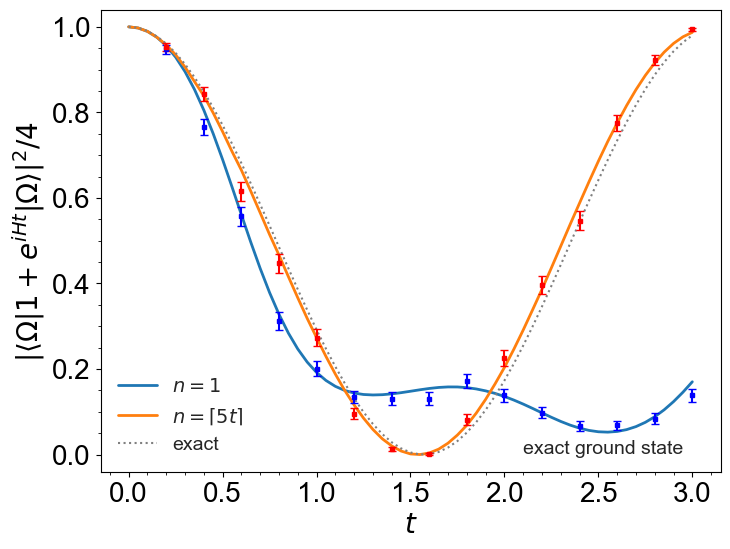

In [29]:
import seaborn as sns

plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(tvals, Exact1Step, label=r'$n = 1$', lw=2)
plt.plot(tvals, Exact5XStep, label=r'$n = \lceil 5t \rceil$', lw=2)
plt.plot(tvals, Exact, label=r'exact', ls=':', color='grey')

plt.errorbar(tsim, Exact1StepSim, yerr=Exact1StepErr, ls='', marker='s', ms=3, capsize=3, color='blue')
plt.errorbar(tsim, Exact5XStepSim, yerr=Exact5XStepErr, ls='', marker='s', ms=3, capsize=3, color='red')

plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(2.1,0.003, 'exact ground state', fontsize=14)

plt.xlabel("$t$",fontsize=20)
plt.ylabel(r'$|\langle \Omega | 1 + e^{iHt} | \Omega\rangle|^2/4$',fontsize=20)
plt.ylim([-0.04,1.04])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("control_exact.pdf",bbox_inches='tight')

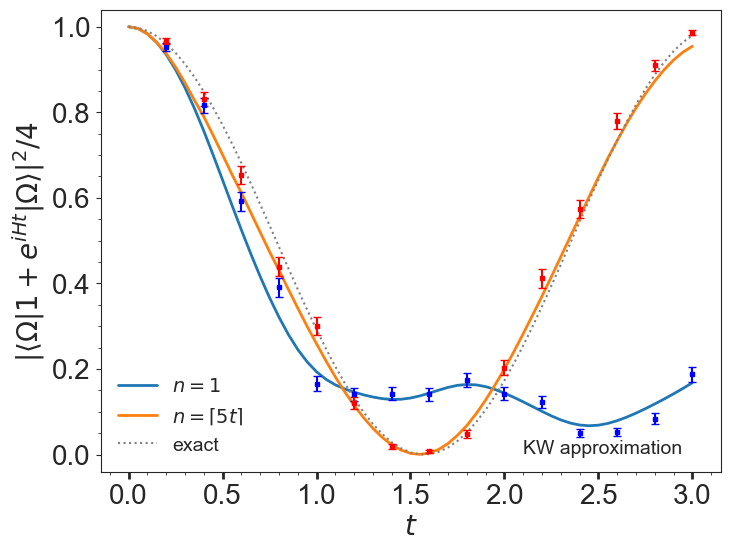

In [30]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(tvals, KW1Step, label=r'$n = 1$', lw=2)
plt.plot(tvals, KW5XStep, label=r'$n = \lceil 5t \rceil$', lw=2)
plt.plot(tvals, Exact, label=r'exact', ls=':', color='grey')

plt.errorbar(tsim, KW1StepSim, yerr=KW1StepErr, ls='', marker='s', ms=3, capsize=3, color='blue')
plt.errorbar(tsim, KW5XStepSim, yerr=KW5XStepErr, ls='', marker='s', ms=3, capsize=3, color='red')

plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(2.1,0.003, 'KW approximation', fontsize=14)

plt.xlabel("$t$",fontsize=20)
plt.ylabel(r'$|\langle \Omega | 1 + e^{iHt} | \Omega\rangle|^2/4$',fontsize=20)
plt.ylim([-0.04,1.04])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("control_KW.pdf",bbox_inches='tight')